<a href="https://colab.research.google.com/github/plaban1981/FASTAI_2021/blob/main/Is_it_a_bird%3F_Creating_a_model_from_your_own_data_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Download images of birds and non-birds

https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data?scriptVersionId=103376231&cellId=8

The basic steps we'll take are:

* Use DuckDuckGo to search for images of "bird photos"
* Use DuckDuckGo to search for images of "forest photos"
* Fine-tune a pretrained neural network to recognise these two groups
* Try running this model on a picture of a bird and see if it works.

In [2]:
! pip install duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 4.3 MB/s 
     |████████████████████████████████| 357 kB 48.2 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.


In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'http://2.bp.blogspot.com/-LZ4VixDdVoE/Tq0ZhPycLsI/AAAAAAAADDM/OKyayfW-z4U/s1600/beautiful_Birds_wallpapers_pictures_Kingfisher_Lilac+Breasted+Roller+Bird.JPG'

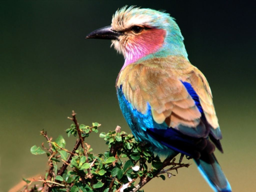

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


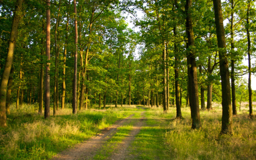

In [6]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [7]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


#### me photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

## Train our model

To train a model, we'll need DataLoaders, 

* Dataloaders which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). 
* In fastai we can create that easily using a DataBlock, and view sample images from it:

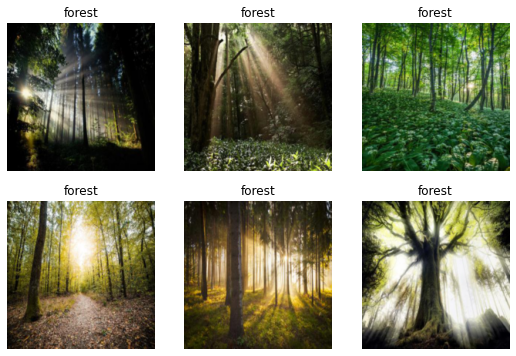

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

* **get_items=get_image_files** :To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).
* **get_y=parent_label** :The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).
* **item_tfms=[Resize(192, method='squish')]** :Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

## Build Model

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

* fastai comes with a helpful fine_tune() method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.926069,0.671693,0.303030,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.116571,0.042442,0.000000,00:01
1,0.074416,0.002495,0.000000,00:01
2,0.049870,0.001883,0.000000,00:01


In [12]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000


In [13]:
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0001


## Saving a Model

In [14]:
learn.export('model.pkl')